# Optimalizácia a simulácia

### Jakub Ševcech, Róbert Móro

IAU, 5.12.2019

## Spätnú väzbu nám môžete nechať tu: https://tinyurl.com/iau2019-w11

## Pýtať sa môžete na http://slido.com#iau2019-w11

# 1. Optimalizácia hyperparametrov

# 2. Algoritmy numerickej optimalizácie

# 3. Simulácia (Monte Carlo)


# Najskôr pár slov k testovacím dátam

Testovacie datasety:
https://drive.google.com/drive/folders/1gmXZxVd0-bB6OWWLK_d92TcUWwMXkIFO?usp=sharing

Ak by ste si nepamätali, ktorý dataset ste si vybrali, tu je zoznam priradení:
https://drive.google.com/open?id=1bbE-VFytMNIdXm6ZYc3Hd1v3kLY_6eSQFxKOUWswotU

Znovu máte 2 súbory. Treba ich spojiť a spraviť predikciu. Nemáte stĺpec *class*. Ten treba predikovať. Sami si neviete overiť úspešnosť na tomto datasete. To spravím ja a porovnám vás

Predikujte číslo z tohto stĺpca

Dajte si pozor aby ste zachovali poradie pozorovaní zo súboru personal_test.csv

Poradie medzi vami vyhodnotíme pomocou stránky Kaggle. Vytvorili sme súťaž, kde sa môžete zapojiť.
https://www.kaggle.com/c/iau-2019


In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn

In [2]:
plt.rcParams['figure.figsize'] = 6, 4

# Optimalizácia hyperparametrov (Hyperparameter Tuning)

Už sme vám hovorili, že existuje veľa metrík na vyhodnocovanie pre regresné úlohy a aj pre klasifikačné. Vždy je dobré vyhodnocovať rôzne metriky aby sme mali rôznorodý pohlaď na to ako dobre funguje náš model: precision a recall hovoria niečo úplne iné a v rôznych situáciách môže byť jedna z nich dôležitejšia (vysoký recall napríklad ak testujete pacientov - nechcete aby vám nejaký chorý prekĺzol a vždy viete použiť ďalší test, vysoký precision ak je drahé pomýliť sa ako napríklad ak hľadáte podvody a každý nesprávne určený podvod znamená žalobu od neprávom obvineného).

Keď ale hľadáte najlepší model, obyčajne optimalizujete len jednu metriku. Optimalizujete výberom algoritmu, ale aj jeho nastavovaním.

Nastavovacie parametrov modelu == hyperparameter tuning


In [3]:
from sklearn import datasets

iris = datasets.load_iris()
X = iris.data
y = iris.target
n_samples, n_features = X.shape
n_samples, n_features

(150, 4)

# Dáta majú len 4 stĺpce. To znamená, že hĺbka rozhodovacieho stromu 4 by mohla stačiť na dobrú klasifikáciu (nie nutne).

Môže sa ale stať, že niektorý model bude chcieť použiť jeden atribút opakovane v jednej vetve stromu


## Pridáme do dát 800 nových stĺpcov, ktoré sú ale úplne náhodné a nemali by nijak prispievať k úspešnosti. Uvidíme, aký vplyv na úspešnosť podľa hĺbky stromu bude mat ten šum

In [4]:
# Trosku zasumime tie data, aby to vyzeralo krajsie
random_state = np.random.RandomState(0)
X = np.c_[X, random_state.randn(n_samples, 200 * n_features)]

In [5]:
X.shape

(150, 804)

## Skúsme teda natrénovať nejaký stromček

In [6]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier

cls = DecisionTreeClassifier()
scores = cross_val_score(cls, X, y, cv=5, scoring = 'f1_macro')
scores.mean()

0.9056508796339191

Dostali sme nejakú úspešnosť. Je to ale dobré číslo alebo nie? Potrebovali by sme si to overiť s niečím iným. Napríklad iným nastavením modelu.

In [7]:
cls = DecisionTreeClassifier(max_depth=2)
scores = cross_val_score(cls, X, y, cv=5, scoring = 'f1_macro')
scores.mean()

0.933266499582289

Zlepšili sme to, ale nedalo by sa to zlepšiť ešte viac? Môžeme skúsiť ďalšie nastavenia, ale nechce sa nám to skúšať manuálne. Nedalo by sa to robiť nejak systematicky a hlavne automaticky?

# GridSearch

In [8]:
from sklearn.model_selection import GridSearchCV
clf = DecisionTreeClassifier

cv_params = {'max_depth': [1,2,3,4] + list(range(5,10,2)), 'criterion': ['gini', 'entropy'], 'min_samples_leaf': [1, 3] }
ind_params = {'random_state': 0}
optimization = GridSearchCV(clf(**ind_params), 
                            cv_params, 
                             scoring = 'f1_macro', cv = 5, n_jobs = -1, verbose=True) 

# GridSearch sa pokúsi zistiť úspešnosť na všetkých možných kombináciách parametrov, ktoré sme zadali do mriežky

In [9]:
from sklearn.model_selection import ParameterGrid
print(len(ParameterGrid(cv_params)))
list(ParameterGrid(cv_params))

28


[{'criterion': 'gini', 'max_depth': 1, 'min_samples_leaf': 1},
 {'criterion': 'gini', 'max_depth': 1, 'min_samples_leaf': 3},
 {'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 1},
 {'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 3},
 {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 1},
 {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 3},
 {'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 1},
 {'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 3},
 {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 1},
 {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 3},
 {'criterion': 'gini', 'max_depth': 7, 'min_samples_leaf': 1},
 {'criterion': 'gini', 'max_depth': 7, 'min_samples_leaf': 3},
 {'criterion': 'gini', 'max_depth': 9, 'min_samples_leaf': 1},
 {'criterion': 'gini', 'max_depth': 9, 'min_samples_leaf': 3},
 {'criterion': 'entropy', 'max_depth': 1, 'min_samples_leaf': 1},
 {'criterion': 'entropy', 'max_depth': 1, 'min_sampl

In [10]:
%%time
optimization.fit(X, y)

Fitting 5 folds for each of 28 candidates, totalling 140 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.0s


Wall time: 3.69 s


[Parallel(n_jobs=-1)]: Done 140 out of 140 | elapsed:    3.6s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=0,
                                              splitter='best'),
             iid='warn', n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [1, 2, 3, 4, 5, 7, 9],
                     

In [11]:
optimization.cv_results_ 

{'mean_fit_time': array([0.01356521, 0.01376123, 0.02034659, 0.01755257, 0.02174101,
        0.0227385 , 0.02593002, 0.0233357 , 0.02433295, 0.02533102,
        0.02473378, 0.0269278 , 0.02652931, 0.02692804, 0.02912202,
        0.02832375, 0.04089017, 0.03929448, 0.04886913, 0.04866996,
        0.04807248, 0.04388218, 0.05305872, 0.05126281, 0.04847031,
        0.04707251, 0.04328566, 0.04847035]),
 'std_fit_time': array([0.00101442, 0.0017142 , 0.00149116, 0.00048887, 0.00222175,
        0.00159628, 0.00109328, 0.00135486, 0.00240934, 0.00264497,
        0.00247562, 0.00227469, 0.0014929 , 0.00538968, 0.00291847,
        0.00162077, 0.00209233, 0.00184958, 0.00178419, 0.00116322,
        0.00818632, 0.00454868, 0.00385617, 0.01308883, 0.00205376,
        0.01010059, 0.0098876 , 0.00348928]),
 'mean_score_time': array([0.00498586, 0.00478806, 0.00119605, 0.00119748, 0.00139685,
        0.00179629, 0.00119724, 0.0015965 , 0.00119691, 0.00119791,
        0.00099802, 0.0009974 , 0.000997

In [12]:
list(filter(lambda x: 'best' in x, dir(optimization)))

['best_estimator_', 'best_index_', 'best_params_', 'best_score_']

In [13]:
optimization.best_estimator_

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=0, splitter='best')

In [14]:
optimization.best_score_

0.9332664995822889

# Veľký pozor na pretrénovanie.

# Prehľadávaním (manuálnym alebo automatickým) priestoru parametrov pridávam ďalší stupeň trénovania. Ideálne by som mal mat ďalšiu testovaciu vzorku, na ktorej ukážem očakávanú úspešnosť.
Tým, že hľadám najlepšiu úspešnosť na testovacej vzorke pridávam ďalšiu úroveň trénovania a hrozí mi problém optimalizácie na testovacie dáta (vid. leaderboard optimization). Ak ma zaujíma očakávaná úspešnosť na dátach, ktoré model nikdy nevidel, tak by som mal mat ešte jednu (validačnú) vzorku, na ktorej overím len ten úplne posledný model. Úspešnosť na tejto vzorke bude úspešnosť, ktorú budem môcť očakávať v produkcii, na dátach, ktoré model nikdy nevidel.


# RandomSearch

Alternatíva ku GridSearchu,

Neprehľadávam systematicky celú mriežku, ale skúšam rôzne hodnoty parametrov náhodne.

Obyčajne nájde riešenie veľmi **blízke** tomu najlepšiemu z GridSearchu na oveľa menej pokusov. Nemusí nájsť to najlepšie (ak by sa to najlepšie vôbec nachádzalo v mriežke).


In [15]:
cv_params

{'max_depth': [1, 2, 3, 4, 5, 7, 9],
 'criterion': ['gini', 'entropy'],
 'min_samples_leaf': [1, 3]}

In [16]:
from scipy import stats

random_params = {
    'max_depth': stats.randint(1,10),
    'criterion': ['gini', 'entropy'],
    'min_samples_leaf': stats.randint(1,5)
}

Čo keby som namiesto vymenovania hodnôt dal náhodnú premennú?

In [17]:
from sklearn.model_selection import RandomizedSearchCV

random_optimization = RandomizedSearchCV(clf(**ind_params), param_distributions = random_params, 
                               n_iter = 10, scoring = 'f1_macro', cv = 5, verbose=True, random_state=42, n_jobs = -1)

Skúsime spustiť optimalizáciu s menším počtom pokusov

In [18]:
%%time
random_optimization.fit(X, y)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Wall time: 495 ms


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.3s finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=DecisionTreeClassifier(class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features=None,
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    presort=False,
                                                    random_state=0,
                                                    splitter='best'),
 

In [19]:
random_optimization.best_estimator_

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=8,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=0, splitter='best')

In [20]:
random_optimization.best_score_

0.9113805979595452

# Viacero veľmi dobrých modelov má podobnú úspešnosť. Možno nám netreba nájsť ten úplne najlepší, ale rýchlo sa dostať k nejakému veľmi dobrému.

In [27]:
sorted(optimization.cv_results_['mean_test_score'], reverse=True)

[0.9332664995822889,
 0.9332664995822889,
 0.9332664995822889,
 0.9332664995822889,
 0.9114484443431813,
 0.9113805979595452,
 0.9113805979595452,
 0.9113805979595452,
 0.9113805979595452,
 0.9064661654135338,
 0.9064661654135338,
 0.9064661654135338,
 0.9064661654135338,
 0.9053742755452273,
 0.9046638059795955,
 0.9046638059795955,
 0.9046638059795955,
 0.9046638059795955,
 0.8928634718108402,
 0.8928634718108402,
 0.8928634718108402,
 0.8928634718108402,
 0.8898319029897979,
 0.8837577341918439,
 0.5555555555555555,
 0.5555555555555555,
 0.5555555555555555,
 0.5555555555555555]

# Random search prehľadáva priestor rovnomernejšie a preto ma šancu skôr nájsť dostatočne dobré riešenie

Naľavo: GridSearch, 
Napravo: RandomSearch

Oba prehľadávajú ten istý priestor parametrov.

Pri obmedzenom počte pokusov má RandomSearch väčšiu šancu prísť k pomerne dobrému riešeniu.

<img src="img/3_boxes.gif" alt="Drawing" style="width: 700px;"/>

Zdroj obrázku: https://sigopt.com/blog/breaking-free-of-the-grid/

Odporúčam zdroj pozrieť aj kvôli ďalším vylepšeniam GridSearchu, ktoré prezentujú.


# Ďalšie zdroje

Veľmi pekný príklad, kde implementujú vlastný GridSearch a RandomSearch a porovnávajú ich. Veľmi pekne vysvetľujú ako fungujú: https://www.kaggle.com/willkoehrsen/intro-to-model-tuning-grid-and-random-search



# Optimalizácia

Rôznych optimalizačných metód je obrovský počet pre rôzne typy úloh.

Teraz vyberám len zopár zaujímavých a vysvetľujem ich čisto intuitívne, nie algoritmicky ani matematicky. Nám to bude teraz stačiť.

Na inžinierskom stupni ale na to bude celý predmet: **Prírodou inšpirované počítanie** - kde by sa mali brať minimálne rôzne prírodou inšpirované optimalizačné algoritmy.


# Hill climbing

**"Like climbing mount Everest in thick fog with amnesia"**

Myšlienka: Pamätať si aktuálny stav a snažiť sa ho lokálne vylepšiť.

1. Vyhodnoť iniciálny stav. Ak je to cieľový stav, tak skonči.

2. Iteruj cez susedné stavy. 

> a. Ak je susedný stav cieľový, tak skonči.

> b. Ak je susedný stav lepší ako aktuálny, tak ho prehlás za aktuálny a pokračuj v kroku 2.

> c. Ak susedný stav nie je lepší ako aktuálny, tak pokračuj v iterácií.

Steepest-Ascent Hill climbing vyberá najlepšieho suseda


Problémy s uviaznutím v lokálnom maxime alebo na plošine. 

Riešenie dlhým skokom alebo backtrackingom.

<img src="img/hill_climbing.png" alt="Drawing" style="width: 700px;"/>

Zdroj obrázku: https://www.geeksforgeeks.org/introduction-hill-climbing-artificial-intelligence/


# Simulovane žíhanie (Simulated annealing)

Jeden z autorov je doc. Vladimír Černý z Matfyzu.

Snaží sa riešiť problémy Hill climbingu.

Metafora z fyziky a obrábania kovov. 

Žíhanie je proces, kde sa postupným pomalým chladnutím kovu vytvára kryštalická mriežka, ktorá robí kov silnejším. Atómy kovu oscilujú a postupne si nachádzajú stabilnejšie pozície.

Simulované žíhanie je vlastne hill climbing, ktorý neberie najlepšieho suseda, ale vyberá suseda náhodne (pravdepodobnosť závisí od vhodnosti) a má nejakú pravdepodobnosť ďalekého skoku. Pravdepodobnosť skokov s časom klesá a algoritmus sa ustaľuje v globálnom maxime.  

<img src="img/Simulated_Annealing.gif" alt="Drawing" style="width: 700px;"/>

Zdroj obrázku: https://en.wikipedia.org/wiki/Simulated_annealing


# Gradientové metódy (metódy najstrmšieho sklonu)

Ak máme spojitú funkciu, ktorú sa snažíme optimalizovať, tak môžeme spočítať deriváciu v aktuálnom bode a nájsť dotyčnicu. Tá ukazuje smer najprudšieho sklonu. Týmto smerom by sme sa mali pohnúť pri optimalizácii.

Netreba počítať hodnoty susedov, stačí derivácia v aktuálnom bode.

Výhodné použiť vo veľarozmerných dátach, kde by bol počet susedov veľmi veľký. Treba ale optimalizovať diferencovateľnú funkciu.

Často sa používajú pri trénovaní neurónových sietí, pretože tam predstavuje každá váha hrany jednu dimenziu. 

Problémy s uviaznutím.

<img src="img/gradient.png" alt="Drawing" style="width: 700px;"/>

Zdroj obrázku: https://www.hackerearth.com/blog/machine-learning/3-types-gradient-descent-algorithms-small-large-data-sets/


Na riešenie problému uviaznutia v lokálnom minime a nastavenia správnej rýchlosti učenia existuje kopec prístupov a veľa špecifických príchutí Gradient descent algoritmu. ADAGRAD napríklad prispôsobuje rýchlosť učenia v procese optimalizácie. ADAM k tomu pridáva momentum (zotrvačnosť), ktoré upravuje gradient ak sa hýbe podobným smerom opakovane. Zabezpečuje to rýchlejšiu konvergenciu a tiež preskakovanie lokálnych miním.

# Bayesovská optimalizácia

Snaží sa trénovať zástupný model (vľavo hore) aproximujúci závislosť úspešnosti modelu od jeho parametrov (vpravo hore). Jednotlivé pokusy zlepšujú zástupný model. Rovnováha medzi exploráciou (skúšanie tam, kde je nízka istota zástupného modelu a teda je tam možné veľké zlepšenie lebo  nevieme čo tam môžeme čakať - vľavo dolu) a exploatáciou (skúšanie tam, kde zástupný model predpovedá vysokú úspešnosť a môžeme ju skúšať ešte zlepšiť - vpravo dolu)

<img src="img/bayesian_optimization.gif" alt="Drawing" style="width: 700px;"/>

zdroj obrazku: https://github.com/fmfn/BayesianOptimization/blob/master/examples/bayesian_optimization.gif


# Ďalšie metódy

## Genetické/evolučné algoritmy 
Riešenie je tvorené agentom, s nejakou genetickou informáciou a fitnes funkciou. Iteratívne sa vytvárajú noví agenti z predchádzajúcej generácie. Najlepší agenti sa vyberajú na základe fitness funkcie a upravuje sa ich genetická informácia. Rôzne mechanizmy kombinovania genetickej informácie rodičov, mutácii, výberu najlepších agentov, ...

## Convex optimizers
Veľa metód numerickej optimalizácie predpokladajúcich, že optimalizovaná funkcia má konvexný tvar a teda nemá lokálne maximá - len jedno globálne.

Hľadanie riešení na základe definovaných obmedzení.

Lineárne programovanie, Kvadratické programovanie


## Swarm intelligence methods
Algoritmy inšpirované správaním biologických systémov: sociálny hmyz (mravce, včely), svorky/čriedy/kŕdle zvierat

Spolupráca a súťaživosť agentov

Často optimalizácia viacerých kritérií naraz


# Teraz zmena, ideme od optimalizácie bokom do inej témy

# Monte Carlo 

<img src="img/monte_carlo.jpg" alt="Drawing" style="width: 700px;"/>

## simulácia 

# Monte Carlo simulácia 

Vynálezca Stanislaw Ulam. Americko-Poľský matematik. Známy prácou na projekte Manhattan. 

Príbeh hovorí, že keď bol v nemocnici chorý, tak sa z nudy snažil spočítať pravdepodobnosť výhry v hre Solitair. Kombinatoriky to bolo príliš zložité spočítať, tak to spolu s Johnom von Neumannon skúsili spočítať simuláciou na počítači Eniac.

Vymyslel tak Monte Carlo simuláciu.

Metóda na odhadnutie neznámej hodnoty pomocou princípov inferenčnej štatistiky

Ak vyberieme vzorku z populácie **náhodne**, vzorka má sklon vykazovať rovnaké vlastnosti ako cela populácia. Čo je vlastne princíp inferenčnej štatistiky. 

Ak dokážeme spočítať nejakú agregovanú hodnotu pre dostatočne veľkú vzorku pozorovaní, tak sa jej hodnota ustabilizuje a my ju môžeme použiť ako odhad skutočnej hodnoty.

Veľmi dobrý zdroj: https://ocw.mit.edu/courses/electrical-engineering-and-computer-science/6-0002-introduction-to-computational-thinking-and-data-science-fall-2016/


## Použime simuláciu na porovnanie rôznych stratégii hrania hry Roulette

Chceme zistiť ktorá z dvoch stratégii ma vyšší stredný očakávaný zárobok po dajme tomu 100 hrách.

Nevieme spočítať zárobok pre všetky možné priebehy 100 opakovaní hry. Ten priestor možných priebehov je obrovský. Vieme ale vybrať vzorku hier a spočítať priemerný zárobok pre ne. Ak sú vzorky vybrané náhodne, tak odhadovaný priemer by sa mal správať rovnako ako skutočný priemer pre celu populáciu – pre všetky možné priebehy. Samozrejme s nejakou mierou istoty.


## Roulette

Kruh rozdelený na 37 dielikov (Európska verzia, Americká ma 38)

Dieliky očíslovane 0-36 (Americká ma 2x0)

Do roztočeného kolesa krupier vhodí loptičku. Tá sa zastaví na niektorom dieliku.

Rovnomerne rozdelenie pravdepodobnosti zastavenia loptičky pre rôzne dieliky.

Možme staviť na farbu (čierna/červená), pár/nepár, presné číslo, rôzne skupiny čísel na hracom stole. 

<img src="img/roulette.png" alt="Drawing" style="width: 700px;"/>


Dôležitá časť - to nenápadné zelené políčko - pri políčku 0 vyhráva kasíno P(0) = 1/37 (2/38 v americkej verzii)=> **Negative sum game**

Negative sum game = rozdiel súčtu všetkých výhier a všetkých vkladov hráčov je negatívny. Hráči do hry spolu vložili viac ako môžu spolu vyhrať. Časť ide nejakému bookmakerovi / krupierovi / kasínu ... 

V rôznych hrách je rôzny mechanizmus ako toto dosiahnuť.


## Poďme si implementovať jednoduchú ruletu

In [28]:
from random import randint

# Pre jednoduchost budeme riesit len stavku na farbu (vzdy cervenu).
def roulette_round():
    values = {0: "c", 32 : "r", 15: "b", 19: "r", 4: "b", 21: "r", 2: "b", 
              25: "r", 17: "b", 34: "r", 6: "b", 27: "r", 13: "b", 36: "r", 
              11: "b", 30: "r", 8: "b", 23: "r", 10: "b", 5: "r", 24: "b", 
              16: "r", 33: "b", 1: "r", 20: "b", 14: "r", 31: "b", 9: "r", 
              22: "b", 18: "r", 29: "b", 7: "r", 28: "b", 12: "r", 35: "b", 
              3: "r", 26: "b"}
    draw = randint(0,36)
    return values[draw] == "r"
    
    
roulette_round()

True

## 1. Veľmi jednoduchá stratégia, opakovane stávkovať rovnakú sumu stále na tú istú farbu

In [29]:
class Simple:
    def __init__(self, credit, wager, round_count):
        self.credit = credit
        self.wager = wager
        self.round_count = round_count
        
    def run(self):
        history = []
        for _ in range(self.round_count):
            if roulette_round():
                self.credit += self.wager
            else:
                self.credit -= self.wager
                
            history.append(self.credit)
        return history
    
s = Simple(1000, 100, 100)
s.run()        

[900,
 1000,
 900,
 1000,
 900,
 800,
 900,
 800,
 700,
 600,
 700,
 800,
 900,
 800,
 700,
 800,
 900,
 800,
 700,
 800,
 700,
 800,
 700,
 800,
 900,
 1000,
 1100,
 1200,
 1100,
 1200,
 1100,
 1000,
 900,
 1000,
 1100,
 1000,
 900,
 1000,
 900,
 800,
 900,
 800,
 900,
 800,
 900,
 1000,
 900,
 1000,
 1100,
 1200,
 1100,
 1200,
 1300,
 1400,
 1300,
 1400,
 1300,
 1400,
 1500,
 1600,
 1500,
 1600,
 1500,
 1600,
 1500,
 1400,
 1300,
 1400,
 1300,
 1400,
 1300,
 1400,
 1500,
 1400,
 1300,
 1200,
 1100,
 1200,
 1100,
 1200,
 1300,
 1200,
 1300,
 1400,
 1500,
 1400,
 1500,
 1600,
 1500,
 1400,
 1500,
 1400,
 1300,
 1200,
 1100,
 1200,
 1300,
 1200,
 1100,
 1000]

## 2. Stratégia Martingale 

* zdvojnásobiť stávku pri prehre
* polovičná stávka po výhre
* spoliehať sa na to, že musím raz vyhrať a veľkou stávkou napraviť predchádzajúce prehry


In [30]:
class Martingale:
    def __init__(self, credit, wager, round_count):
        self.credit = credit
        self.wager = wager
        self.round_count = round_count
        
    def run(self):
        history = []
        for _ in range(self.round_count):
            if roulette_round():
                self.credit += self.wager
                self.wager = self.wager // 2
            else:
                self.credit -= self.wager
                self.wager = self.wager * 2
                
            history.append(self.credit)
        return history
    
m = Martingale(1000, 100, 100)
m.run()        

[900,
 700,
 300,
 -500,
 -2100,
 1100,
 -500,
 -3700,
 2700,
 5900,
 4300,
 7500,
 5900,
 9100,
 7500,
 4300,
 10700,
 13900,
 12300,
 9100,
 15500,
 18700,
 17100,
 13900,
 7500,
 20300,
 26700,
 29900,
 28300,
 31500,
 29900,
 33100,
 31500,
 34700,
 36300,
 35500,
 37100,
 36300,
 37900,
 37100,
 38700,
 37900,
 39500,
 40300,
 40700,
 40500,
 40900,
 41100,
 41200,
 41150,
 41250,
 41200,
 41100,
 40900,
 40500,
 41300,
 41700,
 41500,
 41100,
 41900,
 42300,
 42500,
 42400,
 42200,
 41800,
 41000,
 39400,
 36200,
 42600,
 39400,
 45800,
 49000,
 47400,
 44200,
 37800,
 25000,
 -600,
 50600,
 25000,
 76200,
 101800,
 89000,
 63400,
 12200,
 -90200,
 114600,
 217000,
 165800,
 63400,
 268200,
 165800,
 370600,
 268200,
 63400,
 473000,
 268200,
 677800,
 473000,
 882600,
 677800]

## Spustime simuláciu veľa krát a budeme si odkladať priebežné hodnoty kreditu pre simulovaných hráčov

Vznikne nám dvojrozmerné pole. Vývoj kreditu každého hráča


In [31]:
%%time
s_results = []
for _ in range(10000): # pocet opakovani simulacie
    s = Simple(1000, 100, 100)
    s_results.append(s.run())
    
s_results = np.array(s_results)

Wall time: 2.39 s


In [32]:
# Posledny stlpec su vysledne sumy
s_results[:,-1] 

array([-400,  600, 1400, ..., 1800,    0,    0])

# Keďže teraz už máme veľa realizácií simulácie, tak môžeme začať robiť odhady toho, čo môžeme očakávať a aké sú pravdepodobnosti

In [33]:
pd.Series(s_results[:,-1]).describe()

count    10000.000000
mean       732.080000
std        996.673572
min      -3400.000000
25%          0.000000
50%        800.000000
75%       1400.000000
max       4200.000000
dtype: float64

Čiže v priemere sme skončili na cca 700 eurách. Menej ako 1000 na začiatku, takže v priemere prerobíme.

## Môžeme sa pozrieť na rozdelenie, aby sme vedeli kde je sústredená výsledná výhra.

(array([2.000e+00, 6.000e+00, 2.700e+01, 1.570e+02, 2.990e+02, 1.031e+03,
        1.146e+03, 2.197e+03, 1.563e+03, 1.877e+03, 8.510e+02, 6.040e+02,
        1.560e+02, 7.900e+01, 5.000e+00]),
 array([-3400.        , -2893.33333333, -2386.66666667, -1880.        ,
        -1373.33333333,  -866.66666667,  -360.        ,   146.66666667,
          653.33333333,  1160.        ,  1666.66666667,  2173.33333333,
         2680.        ,  3186.66666667,  3693.33333333,  4200.        ]),
 <a list of 15 Patch objects>)

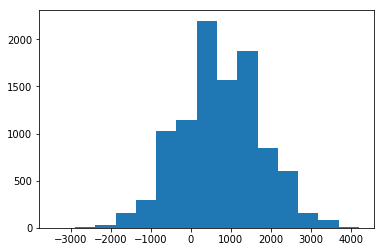

In [34]:
plt.hist(s_results[:,-1], bins=15)

Čiže hlavná váha rozdelenia je trochu posunutá k nižším hodnotám.

# Koľko bolo takých, ktorým zostalo aspoň niečo z pôvodného kreditu?

In [35]:
sum(s_results[:,-1] > 0)

7332

# Koľko bolo takých, ktorí aj niečo  zarobili?

In [36]:
sum(s_results[:,-1] > 1000)

3572

Čiže máme cca 34% šancu, že s takto nastavenou stratégiou zarobíme

stratégia je 100 x staviť na farbu (je jedno akú, my sme zhodou okolnosti dávali tu istú, ale dúfam, že mi budete veriť, že rovnaký výsledkov by sme dostali aj keď by sme farbu menili)


# Malá odbočka - čo je to Gambler's fallacy (Gamblerov klam / chybný zaver)

Stalo sa vám už, že ste napríklad hádzali mincou a opakovane vám padla tá istá hodnota. Intuitívne ste očakávali, že pri ďalšom hode už musí padnúť opačná strana. Že je väčšia pravdepodobnosť, že padne tá druhá hodnota, keď už niekoľko krát za sebou padla tá istá? Aby sa nejak vyrovnala tá nepravdepodobná situácia, že padla veľa krát za sebou rovnaká hodnota?

Poznáte slovenské porekadlo: Do tretice vsetko dobré


18.8.1913 v kasíne v Monte Carlo padla na rulete čierna farba **26** krát za sebou.

Všetci stávkovali proti čiernej lebo verili, že v ďalšom hode už musí spadnúť červená.


* Pravdepodobnosť, že padne čierna 26 krát za sebou: 1/67 108 865

* Pravdepodobnosť, že padne čierna 26 krát za sebou ak už predtým padla 25 krát: 18/37 ~ 1/2

Každý hod je nezávislý, pravdepodobnosť každého jedného je rovnaká. Nijak sa nemení s predchádzajúcimi hodnotami.

Bol to najlepší deň v histórii pre to kasíno. Nie až tak pre tých hráčov.


# Gambler's fallacy sa často mýli s termínom Regression toward the mean. 

Ak dosiahla náhodná premenná extrémnu hodnotu, tak pri ďalšom meraní zvykne nadobúdať hodnotu bližšie k priemernej hodnote.

Ak sme v 10 hodoch mincou za sebou hodili tú istú stranu, tak pri ďalších 10 hodoch bude počet týchto strán pravdepodobne bližšie k priemeru.

## Späť k našej simulácii - jednoduchá stratégia nie je veľmi užitočná

## Čo stratégia Martingale?


In [37]:
%%time

m_results = []
for _ in range(10000):
    m = Martingale(1000, 100, 100)
    m_results.append(m.run())
    
m_results = np.array(m_results)

Wall time: 2.37 s


In [38]:
pd.Series(m_results[:,-1]).describe()

count    1.000000e+04
mean     1.831383e+11
std      1.868385e+13
min     -3.160523e+14
25%      2.089500e+03
50%      2.359400e+04
75%      9.220105e+05
max      1.825879e+15
dtype: float64

Tu sú tie výhry podstatne zaujímavejšie. Aj 25% percentil je viac ako dvojnásobok vkladu. Čiže máme viac ako 75% šancu, že zdvojnásobíme vklad. Tá štandardná odchýlka a extrémy sú ale dosť šialené. Maximum je skoro bilión !!!

# Koľko ľudom na konci niečo zostalo?

In [39]:
sum(m_results[:,-1] > 0)

9657

# A koľko aj niečo zarobilo?

In [40]:
sum(m_results[:,-1] > 1000)

9654

# To je úplná paráda, 95% šanca, že zarobíme.

<img src="img/money.jpg" alt="Drawing" style="width: 700px;"/>

# Prečo to ale už dávno nerobí každý, niečo mi na tom nesedí?

Skúsme sa na to ešte pozrieť podrobnejšie

Ref: No free lunch theorem

* confidence intervaly
* histogramy
* vyvoj kreditu jednotlivych hracov

### Skúsme sa pozrieť na ten vývoj kreditu

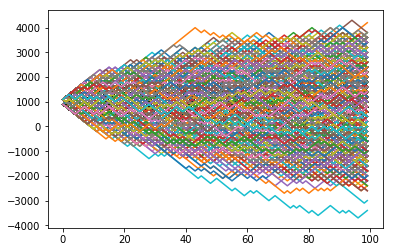

In [41]:
_ = plt.plot(s_results.T)

Toto vyzerá ako papagáj.

Človek nevie vnímať príliš veľké množstvo informácií naraz. Toto je očividné zahltenie. 

Pri tak veľkom množstve čiar nám ich farbičky nepomáhajú odlišovať. Sú tam teda zbytočné. Dajme farbičky preč.


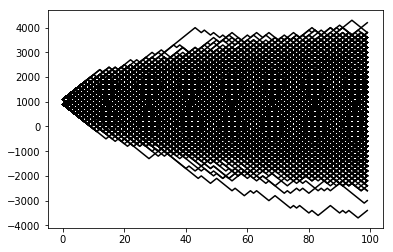

In [42]:
_ = plt.plot(s_results.T, color='black')

Veľmi sme to nevylepšili. Už tam ale aspoň nie sú všetky farby dúhy, ktoré by sme aj tak nevedeli interpretovať a nemali zmysel.  

Chcelo by tam nejak zobraziť hustotou tých čiar. 

Niečo také sa dá dosiahnuť cez priesvitnosť čiar.


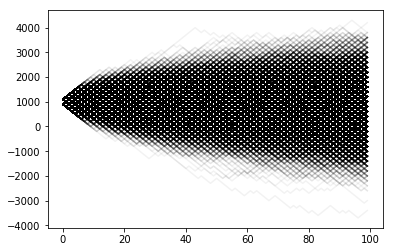

In [43]:
_ = plt.plot(s_results.T, color='black', alpha = 0.05)

Keď vám nejde o jednotlivé pozorovania, ale skôr o nejakú ich hustotu v priestore, tak priesvitnosť je celkom dobrý nápad. 

Veľmi často sa to používa napríklad v scatterplotoch.

Pozor, aj priesvitnosť má svoje obmedzenia. Keď je počet čiar / bodov extrémne vysoký, tak ani priesvitnosť nepomôže a treba siahnuť po iných kladivách.

Vidíme, že väčšina čiar sa drží niekde v strede okolo 1000, ale niektoré idú do extrémov. Tých je ale podstatne menej.

Toto sme čiastočne videli aj v histograme. Tu sme ale pridali ďalší rozmer a vidíme priebeh počas celých hier.


## Zopakujme to isté pre Martingale

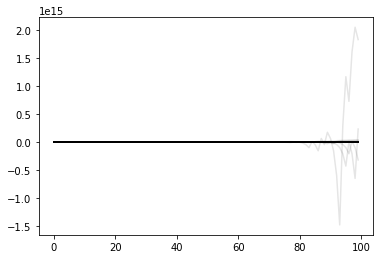

In [44]:
_ = plt.plot(m_results.T, color='black', alpha = 0.1)

Tu nevidíme skoro nič. Potrebovali by sme logaritmickú y-ovú os

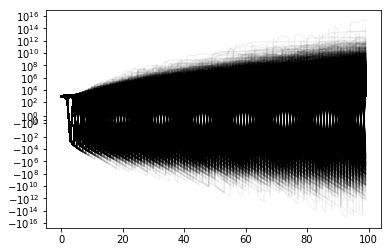

In [45]:
_ = plt.plot(m_results.T, color='black', alpha = 0.05)
plt.yscale('symlog')

Toto je veľmi podobné ako pri druhej stratégii, len sú tam väčšie extrémy a zdá sa, že menej záporných hodnôt.

# Naša simulácia ale nezodpovedá realite. Máme tam chybu

Viete povedať akú?


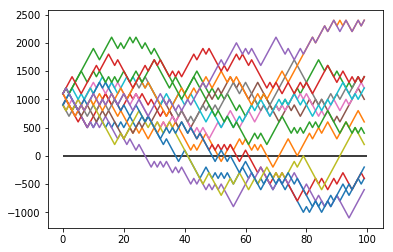

In [46]:
_ = plt.plot(s_results[:15].T)
plt.hlines(0, 0, 100)

# Keď vám v kasíne dôjdu peniaze, tak idete domov. V našej simulácii hráte na dlh.

Skúsme upraviť simuláciu tak aby ste nevedeli hrať na dlh.


In [47]:
class Simple2:
    def __init__(self, credit, wager, round_count):
        self.credit = credit
        self.wager = wager
        self.round_count = round_count
        
    def run(self):
        history = []
        for _ in range(self.round_count):
            if roulette_round():
                self.credit += min(self.credit, self.wager)
            else:
                self.credit -= min(self.credit, self.wager)
                
            history.append(self.credit)
        return history     

In [48]:
class Martingale2:
    def __init__(self, credit, wager, round_count):
        self.credit = credit
        self.wager = wager
        self.round_count = round_count
        
    def run(self):
        history = []
        for _ in range(self.round_count):
            if roulette_round():
                self.credit += self.wager
                self.wager = self.wager // 2
            else:
                self.credit -= self.wager
                self.wager = min(self.credit, self.wager * 2) 
                
            history.append(self.credit)
        return history
    

In [49]:
%%time

s2_results = []
for _ in range(10000):
    s = Simple2(1000, 100, 100)
    s2_results.append(s.run())
    
s2_results = np.array(s2_results)

Wall time: 5.56 s


In [50]:
pd.Series(s2_results[:,-1]).describe()

count    10000.000000
mean       776.100000
std        846.999723
min          0.000000
25%          0.000000
50%        600.000000
75%       1400.000000
max       4600.000000
dtype: float64

In [51]:
sum(s2_results[:,-1] > 1000)

3365

In [52]:
pd.Series(s_results[:,-1]).describe()

count    10000.000000
mean       732.080000
std        996.673572
min      -3400.000000
25%          0.000000
50%        800.000000
75%       1400.000000
max       4200.000000
dtype: float64

In [53]:
sum(s_results[:,-1] > 1000)

3572

Počet takých, čo zarobili zostal cca rovnaký, priemerná očakávaná suma sa trochu zlepšila lebo nám to ti negatívni neťahajú dolu.

In [54]:
%%time

m2_results = []
for _ in range(10000):
    m = Martingale2(1000, 100, 100)
    m2_results.append(m.run())
    
m2_results = np.array(m2_results)

Wall time: 5.17 s


In [55]:
pd.Series(m2_results[:,-1]).describe()

count    10000.000000
mean       880.071500
std       1680.275643
min          0.000000
25%          0.000000
50%          0.000000
75%       1390.000000
max      29144.000000
dtype: float64

(array([9.329e+03, 4.830e+02, 1.090e+02, 4.000e+01, 1.900e+01, 1.300e+01,
        5.000e+00, 0.000e+00, 1.000e+00, 1.000e+00]),
 array([    0. ,  2914.4,  5828.8,  8743.2, 11657.6, 14572. , 17486.4,
        20400.8, 23315.2, 26229.6, 29144. ]),
 <a list of 10 Patch objects>)

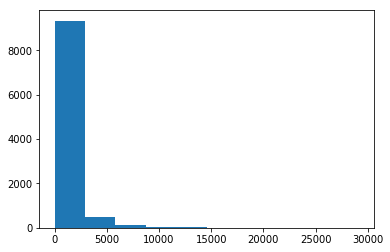

In [56]:
plt.hist(m2_results[:,-1])

In [57]:
sum(m2_results[:,-1] > 1000)

3694

In [58]:
pd.Series(m_results[:,-1]).describe()

count    1.000000e+04
mean     1.831383e+11
std      1.868385e+13
min     -3.160523e+14
25%      2.089500e+03
50%      2.359400e+04
75%      9.220105e+05
max      1.825879e+15
dtype: float64

In [59]:
sum(m_results[:,-1] > 1000)

9654

Pri stratégii Martingale je ale obrovský rozdiel po úprave. Zrazu zmizlo veľmi veľa extrémnych hodnôt a pribudlo veľmi veľa bankrotov. Už sa to nezdá ako až taká dobrá stratégia.

## Skúsme sa pozrieť na priebehy kreditov

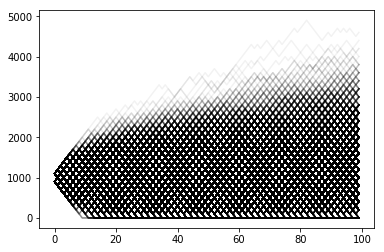

In [60]:
_ = plt.plot(s2_results.T, color='black', alpha = 0.05)

Keď raz zbankrotujem, tak už sa z toho nedostanem

## To isté pre Martingale

Teraz už nepotrebujem ani tu logaritmickú mierku na y-ovej osi.


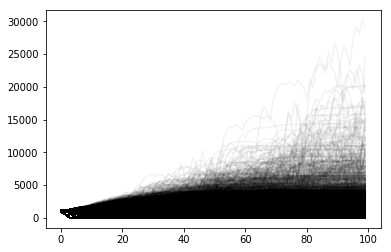

In [61]:
_ = plt.plot(m2_results.T, color='black', alpha = 0.05)
# plt.yscale('log')

Čiže Martingale ako tak funguje ak môžete ísť do neobmedzeného dlhu. V realite vám to ale asi ťažko niekto dovolí. V realite máte malú šancu na veľmi vysokú výhru, ale oveľa väčšiu šancu, že prídete o všetko.

# A čo sa stane ak by sme hrali dlho?

Doteraz sme vždy spravili 100 stávok (ak sme mali na to peniaze)

Simple2 bola stabilnejšia stratégia. Čo sa stane ak budem stávkovať dlho. Napríklad 10000 krát.


In [62]:
%%time

sl_results = []
for _ in range(1000): # tu ich dam simulovat len 1000 lebo sa mi nechce cakat
#     s = Simple2(1000, 100, 100)
    s = Simple2(1000, 100, 10000) # zmenil som dlzku hrania pre kazdeho agenta
    sl_results.append(s.run())
    
sl_results = np.array(sl_results)

Wall time: 26.8 s


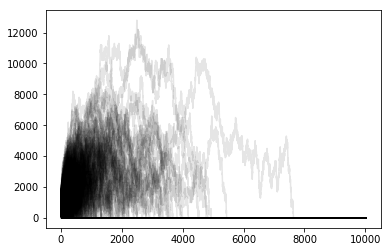

In [63]:
_ = plt.plot(sl_results.T, color='black', alpha = 0.1)

## Pocet takych, ktori zarobili alebo aspon nezbankrotovali

In [64]:
sum(sl_results[:,-1] > 1000)

0

In [65]:
sum(sl_results[:,-1] > 0)

0

In [66]:
pd.Series(sl_results[:,-1]).describe()

count    1000.0
mean        0.0
std         0.0
min         0.0
25%         0.0
50%         0.0
75%         0.0
max         0.0
dtype: float64

# Čiže pri dlhom hraní takmer určite prerobíte. 

Toto je vplyv **negative sum game**

Aj mala nesymetria (1/37) pri opakovaných pokusoch spraví obrovský efekt.

Nikdy sa nepokúšajte gamblovať na negative sum game, kde ide len o náhodu.

Iné príklady negative sum game kde ide len o náhodu: ruská ruleta, väčšina lotérií (výnimkou sú len ojedinelé chyby v nastavení pravidiel)

Negative sum game, kde sa dajú použiť schopnosti na prekonanie negatívneho faktoru: obchodovanie a burze, stávkovanie na športy. 

Váš model ale musí byť tak dobrý, že prekoná aj poistku druhej strany (0 v rulete, znížený kurz v stávkovaní, remíza v black jacku, poplatky za transakcie na burze, ...)

Keď už chcete gamblovat, tak hľadajte **zero sum game** kde viete zapojiť schopnosti a staňte sa fakt dobrými.

Ak sa niekedy dozviete o nejakej **positive sum game**, kde aj vyplácajú výhry, tak poprosím tip :)


# Späť k Monte Carlo simuláciám

Užitočné pri odhadovaní nejakej neznámej hodnoty. Vyhodnotenie na dostatočne veľkej náhodnej podmnožine produkuje stabilné výsledky. Dôležité je sledovať aj stabilitu výsledkov napríklad pomocou confidence intervalov alebo štandardnej odchýlky. Pri rastúcom počte behov simulácie by mala sledovaná metrika konvergovať.


# Kde sa Monte Carlo používa?

* Predpoveď počasia
* Predpoveď demografického vývoja - koľko ľudí bude v dôchodkovom veku o 50 rokov ak poznáme základné štatistické informácie o populácii?
* Overovanie obchodovacích stratégií na burze
* Výpočet sily atómovej bomby
* Simulácia dopravnej situácie
* ...


<img src="img/long_light.png" alt="Drawing" style="width: 700px;"/>

# Čo si zobrať z tejto prednášky

* Optimalizujte hyperparametre. Môžete vášmu algoritmu dosť pomôcť.

* Nepreháňajte to ale veľmi. Môže sa vám stať, že sa preučíte na validačnú vzorku a na testovacích dátach budete mat horšiu úspešnosť ako očakávate.

* Informované optimalizačné metódy vedia veľmi urýchliť prehľadávanie priestoru hyperparametrov.

* Existuje veľmi veľa optimalizačných metód užitočných v rôznych doménach.

* Simulácie nám umožňujú odhadnúť neznámu hodnotu, ktorú by sme inak počítali len veľmi ťažko.

* Nestávkujte na negative sum game, kde nejde o zručnosť ale len o náhodu. Je to ekvivalentne ruskej rulete!!!
